<strong><b><font size="6">Text Classification on Amazon Fine Food Reviews Dataset</font></b></strong>


# Importing Libraries

In [2]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection
import sklearn.preprocessing as preproc
from sklearn.feature_extraction import text
import pickle
import warnings
warnings.filterwarnings("ignore")

# Inspecting Dataset

In [3]:
# Source of dataset: http://snap.stanford.edu/data/web-FineFoods.html

df = pd.read_csv('Reviews.csv', index_col=0)
df = df.dropna()

In [4]:
df.shape

(568411, 9)

In [9]:
df.head(2)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


# Data Cleansing

- __Deduplication__ Removing the dublicate rows, which share the same UserId, ProfileName, Time, and Text

In [5]:
df.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'}, inplace=True)

In [6]:
df.shape

(393919, 9)

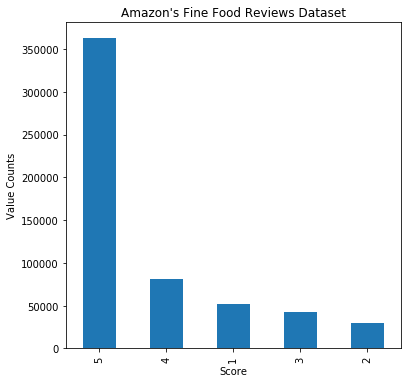

In [19]:
ax = df['Score'].value_counts().plot(kind='bar', figsize=(6,6))
fig = ax.get_figure()
ax.set_title("Amazon's Fine Food Reviews Dataset")
ax.set_xlabel('Score')
ax.set_ylabel('Value Counts');

- Dataset has 5-star rating system and ratings are highly unbalanced. Due to high number of 5-star rating, I have decided to ***label*** score 4 and 5 as positive and else negative. 

In [8]:
df['Label'] = 0
df.loc[df['Score'] > 3, ['Label']] = 1

In [9]:
len(df[df['Label'] == 1])/len(df)

0.7794724296111637

# Text Preprocessing

In [10]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [11]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
        
    return text

In [12]:
df['Text_Cleaned'] = list(map(clean_text, df.Text))

In [13]:
def lemmatized_words(text):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda word:
                                     list(map(lemm.lemmatize, word)),
                                     df.Text_Cleaned))
    

lemmatized_words(df.Text_Cleaned)

In [14]:
df.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Label,Text_Cleaned,lemmatized_text
Id,,,,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,"[bought, several, vitality, canned, dog, food,...","[bought, several, vitality, canned, dog, food,..."
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,"[product, arrived, labeled, jumbo, salted, pea...","[product, arrived, labeled, jumbo, salted, pea..."
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1,"[confection, around, centuries, light, pillowy...","[confection, around, century, light, pillowy, ..."


In [15]:
pd.set_option('max_colwidth', 500)
df[['Score', 'Text', 'Label', 'Text_Cleaned', 'lemmatized_text']].sample(3)

,Score,Text,Label,Text_Cleaned,lemmatized_text
Id,,,,,
528825,5,"This tea is wonderful, subtle pleasant flavors are abundant and refreshing. I have had it for over 8 months now and really enjoying it!",1,"[tea, wonderful, subtle, pleasant, flavors, abundant, refreshing, 8, months, really, enjoying]","[tea, wonderful, subtle, pleasant, flavor, abundant, refreshing, 8, month, really, enjoying]"
18530,3,My twins love this!! BUT Walmart sells them for $1/ for a 2pack! Worth going there to save the extra $!,0,"[twins, love, walmart, sells, 1, 2pack, worth, going, save, extra]","[twin, love, walmart, sell, 1, 2pack, worth, going, save, extra]"
156950,5,I'm an addict. I cant NOT eat the whole bag in under 5 min. This is the best snack food that I have ever had.,1,"[addict, cant, eat, whole, bag, 5, min, best, snack, food, ever]","[addict, cant, eat, whole, bag, 5, min, best, snack, food, ever]"


In [20]:
bow_converter = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
x = bow_converter.fit_transform(df['Text_Cleaned'])

words = bow_converter.get_feature_names()
len(words)

110422

In [28]:
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2], lowercase=False) 
x2 = bigram_converter.fit_transform(df['Text_Cleaned'])
bigrams = bigram_converter.get_feature_names()
len(bigrams)

4189296

In [29]:
bigrams[-10:]

['× piperita',
 'â many',
 'çaykur teas',
 'çelem fermented',
 'être fort',
 'île de',
 'ît real',
 'ø lipton',
 'ø mahatma',
 'ø zatarains']

In [30]:
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False) 
x3 = trigram_converter.fit_transform(df['Text_Cleaned'])
trigrams = trigram_converter.get_feature_names()
len(trigrams)

11572565

In [31]:
trigrams[:10]

['\x10 i wonder',
 '\x13 2852 said',
 '0 0 0',
 '0 0 4',
 '0 0 <',
 '0 0 amazon',
 '0 0 kj',
 '0 0 markets',
 '0 0 official',
 '0 0 zero']

In [32]:
print(len(words), len(bigrams), len(trigrams))

110422 4189296 11572565


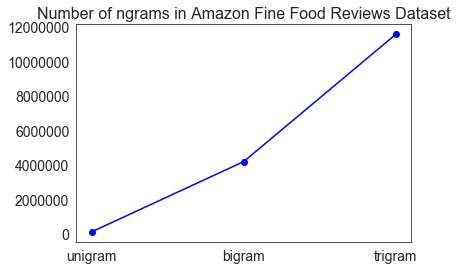

In [69]:
sns.set_style("white")
counts = [len(words), len(bigrams), len(trigrams)]
plt.plot(counts, color='blue')
plt.plot(counts, 'bo')
#plt.margins(0.1)
plt.ticklabel_format(style = 'plain')
plt.xticks(range(3), ['unigram', 'bigram', 'trigram'])
plt.tick_params(labelsize=14)
plt.title('Number of ngrams in Amazon Fine Food Reviews Dataset', {'fontsize':16})
plt.show()

# Bag of Words Transformation

In [37]:
training_data, test_data = sklearn.model_selection.train_test_split(df, train_size = 0.7, random_state=42)

In [38]:
print(training_data.shape)
print(test_data.shape)

(275743, 12)
(118176, 12)


In [39]:
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False) 

In [40]:
X_tr_bow = bow_transform.fit_transform(training_data['Text_Cleaned'])

In [41]:
len(bow_transform.vocabulary_)

8381084

In [42]:
X_tr_bow.shape

(275743, 8381084)

In [43]:
X_te_bow = bow_transform.transform(test_data['Text_Cleaned'])

In [44]:
y_tr = training_data['Label']
y_te = test_data['Label']

# Tf-Idf Tranformation

In [46]:
tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow)

In [47]:
X_te_tfidf = tfidf_transform.transform(X_te_bow)

# Classification with Logistic Regression

In [48]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    model = LogisticRegression(C=_C).fit(X_tr, y_tr)
    score = model.score(X_test, y_test)
    print('Test Score with', description, 'features', score)
    return model

In [50]:
model_bow = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')
model_tfidf = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test Score with bow features 0.8083367181153533
Test Score with tf-idf features 0.8164601949634444


In [51]:
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
bow_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
tfidf_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5,
                                   param_grid=param_grid_)

In [54]:
bow_search.fit(X_tr_bow, y_tr)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [55]:
bow_search.best_score_

0.8138520247638455

In [56]:
tfidf_search.fit(X_tr_tfidf, y_tr)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [57]:
tfidf_search.best_score_

0.8255078144636074

In [58]:
bow_search.best_params_

{'C': 100.0}

In [59]:
tfidf_search.best_params_

{'C': 100.0}

In [60]:
bow_search.cv_results_

{'mean_fit_time': array([ 18.89421639,  53.98715034, 176.28281908, 202.53304782,
        169.9196939 , 168.59854612]),
 'std_fit_time': array([ 1.44400798,  5.60739542, 12.42691595, 17.72046194,  3.24603589,
         1.4596325 ]),
 'mean_score_time': array([0.06471701, 0.04454479, 0.06270566, 0.06888084, 0.05185442,
        0.05487585]),
 'std_score_time': array([0.01628924, 0.00395706, 0.01339407, 0.01686594, 0.00671052,
        0.00709471]),
 'param_C': masked_array(data=[1e-05, 0.001, 0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1e-05},
  {'C': 0.001},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0}],
 'split0_test_score': array([0.77903498, 0.77907124, 0.79339607, 0.80552685, 0.80806542,
        0.8135415 ]),
 'split1_test_score': array([0.77903498, 0.77912564, 0.79424831, 0.80558124, 0.80942537,
        0.81595315]),
 'split2_test_score': array([0.77890805, 0.7

In [61]:
results_file = open('tfidf_gridcv_results.pkl', 'wb')
pickle.dump(bow_search, results_file, -1)
pickle.dump(tfidf_search, results_file, -1)
results_file.close()

In [62]:
pkl_file = open('tfidf_gridcv_results.pkl', 'rb')
bow_search = pickle.load(pkl_file)
tfidf_search = pickle.load(pkl_file)
pkl_file.close()

In [63]:
search_results = pd.DataFrame.from_dict({'bow': bow_search.cv_results_['mean_test_score'],
                               'tfidf': tfidf_search.cv_results_['mean_test_score']})
search_results

,bow,tfidf
0,0.779004,0.779037
1,0.779026,0.790566
2,0.794080,0.803513
3,0.804242,0.810407
4,0.808539,0.822487
5,0.813852,0.825508


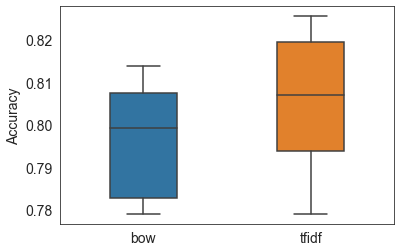

In [64]:
%matplotlib inline
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=14)
plt.savefig('tfidf_gridcv_results.png')

In [66]:
model_bow = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow', 
                              _C=bow_search.best_params_['C'])
model_tfidf = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf', 
                              _C=tfidf_search.best_params_['C'])

Test Score with bow features 0.8199465204440834
Test Score with tf-idf features 0.8244482805307338
